In [1]:
import wfdb
from scipy import signal
import scipy
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
import pywt

c:\Users\Ahmed\.conda\envs\NN\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read Record

In [2]:
fs = 1000
# best start = 1300, best end = 3200
patient_1 = wfdb.rdrecord('..//01.Dataset/117/s0291lre', channels=[1])
patient_2 = wfdb.rdrecord('..//01.Dataset/116/s0302lre', channels=[1])
patient_3 = wfdb.rdrecord('..//01.Dataset/105/s0303lre', channels=[1])
patient_4 = wfdb.rdrecord('..//01.Dataset/104/s0306lre', channels=[1])
patient_5 = wfdb.rdrecord('..//01.Dataset/122/s0312lre', channels=[1])

signal_1 = patient_1.p_signal[: ,0]
signal_2 = patient_2.p_signal[:, 0]
signal_3 = patient_3.p_signal[:, 0]
signal_4 = patient_4.p_signal[:, 0]
signal_5 = patient_5.p_signal[:, 0]

time = len(signal_1)/ fs


In [3]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(input_signal, low_cutoff, high_cutoff, sampling_rate, order):
    nyq = 0.5 * sampling_rate
    low = low_cutoff / nyq
    high = high_cutoff / nyq
    numerator, denominator = butter(order, [low, high], btype='band', output='ba', analog=False, fs=None)
    filtered = filtfilt(numerator, denominator, input_signal)
    return filtered

def smoothMAconv(depth,temp, scale): # Moving average by numpy convolution
    dz = np.diff(depth) 
    N = int(scale/dz[0])
    smoothed=np.convolve(temp, np.ones((N,))/N, mode='same') 
    return smoothed

def get_onset_offset(X, Y, signal):
    a_norm = math.sqrt((Y[0]-X[0])**2 + (Y[1]-X[1])**2)
    
    a = np.array([[X[0], X[1]], [Y[0], Y[1]]])

    c_x = X[0]
    prev_sigma_max = -1
    max_x = -1
    while True:
        if X[0] > Y[0]:
            if c_x <= Y[0]:
                return max_x
            c_x -= 1
        else:
            if c_x >= Y[0]:
                return max_x
            c_x += 1
        
        c = np.array([[X[0], X[1]], [c_x, signal[int(c_x)]]])
        
        ac_cross = np.cross(a, c)
        m_cross = (a[0][0]-a[1][0]) * (c[0][1]-c[1][1]) - (a[0][1]-a[1][1]) * (c[0][0]-c[1][0])
        
        ac_norm = np.linalg.norm(ac_cross)
        sigma = ac_norm / a_norm
        if X[0] > Y[0]:
            sigma = m_cross
        else:
            sigma = -m_cross

        if sigma > prev_sigma_max:
            prev_sigma_max = sigma
            max_x = int(c_x)



In [4]:
def processing(signal):
    # STEPS 1 to 4
    # 1. Bandpass (low pass / high pass)
    y_lfiltered = butter_bandpass_filter(signal, low_cutoff=1.0, high_cutoff=40.0, sampling_rate=1000, order=2)
    denoised_signal = y_lfiltered

    # 2. Differentiation
    y_lfiltered = np.gradient(y_lfiltered)

    # 3. Squaring
    y_lfiltered = y_lfiltered ** 2

    # 4. Window smoothing
    n = 40
    y_lfiltered=np.convolve(y_lfiltered, np.ones((n,))/n, mode='same')

    # Resize for next processing
    y_lfiltered = y_lfiltered * 1000
    window_smoothed_signal = y_lfiltered.copy()
    return denoised_signal,y_lfiltered,window_smoothed_signal

In [5]:
def process_signal(denoised_signal, y_lfiltered):
    # Reduce all values close to zero to be zero
    y_lfiltered[y_lfiltered < 0.1] = 0

    # Get Q and S
    qx = []
    qy = []
    sx = []
    sy = []
    qrs_state = False

    for i in range(len(y_lfiltered)):
        if not qrs_state:
            if y_lfiltered[i] != 0:
                qx.append(i)
                qy.append(denoised_signal[i])
                qrs_state = True
        else:
            if y_lfiltered[i] == 0:
                sx.append(i)
                sy.append(denoised_signal[i])
                qrs_state = False

    # Remove invalid QRS (Incomplete QRS)
    if qrs_state:
        idx = qx.pop()
        for i in range(idx, len(y_lfiltered)):
            y_lfiltered[i] = 0
        qy.pop()

    # Fix s and q (Crawl towards correct value)
    for i in range(len(qx)):
        idx = qx[i]
        while True:
            if denoised_signal[idx - 1] < denoised_signal[idx]:
                qx[i] = idx - 1
                qy[i] = denoised_signal[idx - 1]
            else:
                break
            idx -= 1
        idx = qx[i]
        while True:
            if denoised_signal[idx + 1] < denoised_signal[idx]:
                qx[i] = idx + 1
                qy[i] = denoised_signal[idx + 1]
            else:
                break
            idx += 1

    for i in range(len(sx)):
        idx = sx[i]
        while True:
            if denoised_signal[idx - 1] < denoised_signal[idx]:
                sx[i] = idx - 1
                sy[i] = denoised_signal[idx - 1]
            else:
                break
            idx -= 1
        idx = sx[i]
        while True:
            if denoised_signal[idx + 1] < denoised_signal[idx]:
                sx[i] = idx + 1
                sy[i] = denoised_signal[idx + 1]
            else:
                break
            idx += 1

    qx = np.array(qx)
    qy = np.array(qy)
    sx = np.array(sx)
    sy = np.array(sy)

    return qx, qy, sx, sy

In [6]:
def process_qrs(denoised_signal, y_lfiltered, window_smoothed_signal,qx, qy, sx, sy):
    # Thresholding (Get R, any value not the peak between Q and S is set to 0)
    for i in range(len(qx)):
        y_lfiltered[qx[i]:sx[i]][y_lfiltered[qx[i]:sx[i]]
                                 != max(y_lfiltered[qx[i]:sx[i]])] = 0


    # Remove any peaks that are not Rs
    y_lfiltered[y_lfiltered < max(y_lfiltered) * 0.65] = 0

    # Retrieve R
    Rx = []
    Ry = []
    for i in range(len(y_lfiltered)):
        if y_lfiltered[i] != 0:
            Rx.append(i)
            Ry.append(denoised_signal[i])

    # Fix R (Crawl to correct value)
    for i in range(len(Rx)):
        idx = Rx[i]
        while True:
            if denoised_signal[idx - 1] > denoised_signal[idx]:
                Rx[i] = idx - 1
                Ry[i] = denoised_signal[idx - 1]
            else:
                break
            idx -= 1
        idx = Rx[i]
        while True:
            if denoised_signal[idx + 1] > denoised_signal[idx]:
                Rx[i] = idx + 1
                Ry[i] = denoised_signal[idx + 1]
            else:
                break
            idx += 1

    Rx = np.array(Rx)
    Ry = np.array(Ry)


    # Get QRS onset and offset
    qrs_off_x = []
    qrs_on_x = []
    qrs_off_y = []
    qrs_on_y = []
    for x in Rx:
        X = np.array([x, window_smoothed_signal[x]])
        Y = np.array([x - 300, window_smoothed_signal[x - 300]])
        qrs_on_x.append(get_onset_offset(X, Y, window_smoothed_signal))
        qrs_on_y.append(denoised_signal[qrs_on_x[-1]])

        Y = np.array([x + 200, window_smoothed_signal[x + 200]])
        qrs_off_x.append(get_onset_offset(X, Y, window_smoothed_signal))
        qrs_off_y.append(denoised_signal[qrs_off_x[-1]])

    qrs_on_x = np.array(qrs_on_x)
    qrs_off_x = np.array(qrs_off_x)
    qrs_on_y = np.array(qrs_on_y)
    qrs_off_y = np.array(qrs_off_y)
    return qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y


In [7]:
def plot_signals(time, fs, denoised_signal, window_smoothed_signal, qx, qy, sx, sy):
    # Plot
    ts = np.arange(0, time, 1.0 / fs)  # time vector

    fig = plt.figure(figsize=[15, 10.4])
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    fig.suptitle("Signals")
    axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
    axs[1].plot(ts, window_smoothed_signal, alpha=0.6,
                lw=1, label="SciPy lfilter")

    axs[0].scatter(qx / fs, qy, color="red", s=7)
    axs[0].scatter(sx / fs, sy, color="green", s=7)
    #axs[0].scatter(Rx / fs, Ry, color="blue", s=7)

    plt.show()

In [8]:
def plot_qrs_results(time, fs, denoised_signal, y_lfiltered, qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y):
    # Plot
    ts = np.arange(0, time, 1.0 / fs)  # time vector

    fig = plt.figure(figsize=[15, 10.4])
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    fig.suptitle("Signals")
    axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
    axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

    axs[0].scatter(qrs_on_x / fs, qrs_on_y, color="yellow", s=7)
    axs[0].scatter(qrs_off_x / fs, qrs_off_y, color="lime", s=7)
    axs[0].scatter(qx / fs, qy, color="red", s=7)
    axs[0].scatter(sx / fs, sy, color="green", s=7)
    axs[0].scatter(Rx / fs, Ry, color="blue", s=7)

    plt.show()


def extract_p_wave(fs, qrs_on_x, denoised_signal):
    # Get P wave
    window_size = int(fs * 0.2)  # 200 ms window
    Px = []
    Py = []
    for loc in qrs_on_x:
        loc = qrs_on_x[0]  # QRS onset
        start_idx = int(loc - window_size)
        
        px = 0
        py = -5
        for i in range(start_idx, loc):
            if denoised_signal[i] > py:
                py = denoised_signal[i]
                px = i
        Py.append(py)
        Px.append(px)
    Px = np.array(Px)
    Py = np.array(Py)
    return Px, Py


def calculate_p_onset_offset(Px, denoised_signal):
    window_size = int(fs * 0.2)  # 200 ms window
    p_on_x = []
    p_off_x = []
    p_on_y = []
    p_off_y = []

    for x in Px:
        X = np.array([x, denoised_signal[x]])
        Y = np.array([x - window_size, denoised_signal[x - window_size]])
        p_on_x.append(get_onset_offset(X, Y, denoised_signal))
        p_on_y.append(denoised_signal[p_on_x[-1]])

        Y = np.array([x + 50, denoised_signal[x + 50]])
        p_off_x.append(get_onset_offset(X, Y, denoised_signal))
        p_off_y.append(denoised_signal[p_off_x[-1]])

    p_on_x = np.array(p_on_x)
    p_off_x = np.array(p_off_x)
    p_on_y = np.array(p_on_y)
    p_off_y = np.array(p_off_y)

    return p_on_x, p_off_x, p_on_y, p_off_y


def calculate_t_wave(qrs_off_x, denoised_signal):
    window_size = int(fs * 0.4)  # 400 ms window
    Tx = []
    Ty = []

    for loc in qrs_off_x:
        tx = 0
        ty = 5
        start_idx = int(loc + window_size)
        for i in range(loc, start_idx):
            if(i+50<len(denoised_signal)):
                w1 = denoised_signal[i - 50] - denoised_signal[i]
               
                w2 = denoised_signal[i] - denoised_signal[i + 50]
                w = w1 * w2
                if w < ty:
                    ty = w
                    tx = i

        Tx.append(tx)
        Ty.append(denoised_signal[tx])
    Tx = np.array(Tx)
    Ty = np.array(Ty)
    return Tx, Ty


def calculate_t_onset_offset(Tx, denoised_signal):
    t_off_x = []
    t_on_x = []
    t_off_y = []
    t_on_y = []

    for x in Tx:
        X = np.array([x, denoised_signal[x]])
        Y = np.array([x - 200, denoised_signal[x - 200]])
        t_on_x.append(get_onset_offset(X, Y, denoised_signal))
        t_on_y.append(denoised_signal[t_on_x[-1]])
        if(x+150 <len(denoised_signal)):
            Y = np.array([x + 150, denoised_signal[x + 150]])
        else:
            Y = np.array([len(denoised_signal)-1, denoised_signal[-1]])
        t_off_x.append(get_onset_offset(X, Y, denoised_signal))
        t_off_y.append(denoised_signal[t_off_x[-1]])

    t_on_x = np.array(t_on_x)
    t_off_x = np.array(t_off_x)
    t_on_y = np.array(t_on_y)
    t_off_y = np.array(t_off_y)

    return t_on_x, t_off_x, t_on_y, t_off_y


def plot_signals_with_t(denoised_signal, y_lfiltered, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y,
                        qx, qy, sx, sy, Rx, Ry, Px, Py, p_on_x, p_on_y, p_off_x, p_off_y,
                        Tx, Ty, t_on_x, t_on_y, t_off_x, t_off_y, time, fs):
    ts = np.arange(0, time, 1.0 / fs)  # time vector

    fig = plt.figure(figsize=[15, 10.4])
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    fig.suptitle("Signals")
    axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
    axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

    axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
    axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
    axs[0].scatter(qx/fs, qy, color="red", s=7)
    axs[0].scatter(sx/fs, sy, color="green", s=7)
    axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

    axs[0].scatter(Px/fs, Py, color="#17becf", s=7)
    axs[0].scatter(p_on_x/fs, p_on_y, color="#e377c2", s=7)
    axs[0].scatter(p_off_x/fs, p_off_y, color="black", s=7)

    axs[0].scatter(Tx/fs, Ty, color="#bcbd22", s=7)
    axs[0].scatter(t_on_x/fs, t_on_y, color="orange", s=7)
    axs[0].scatter(t_off_x/fs, t_off_y, color="brown", s=7)

    plt.show()


def calculate_non_fiducial(Rx, denoised_signal):
    RR_previous = Rx[1] - Rx[0]
    RR_next = Rx[2] - Rx[1]

    nonFiducial = []

    after_Rpeak = int(2/3 * ((RR_previous + RR_next) / 2))

    for i in range(int(Rx[1]), int(Rx[1]) + after_Rpeak):
        nonFiducial.append(denoised_signal[i])

    Before_Rpeak = int(1/3 * ((RR_previous + RR_next) / 2))

    for i in range(Before_Rpeak, int(Rx[1])):
        nonFiducial.append(denoised_signal[i])
    plt.plot(nonFiducial)
    return nonFiducial


def extract_non_fiducial_feature(nonFiducial):
    # Define the mother wavelet
    wavelet = pywt.Wavelet('db4')

    # Define the number of levels for decomposition
    decomp_levels = 5

    # Define the list of ECG signals
    ecg_segments = np.array(nonFiducial)  # Example data

    # Decompose the signal
    decomp = pywt.wavedec(ecg_segments, wavelet, level=decomp_levels)

    CA5, CD5, CD4, CD3, CD2, CD1 = decomp

    # Only the coefficients of ECG band (1-40) use them as a feature
    non_fiducial_feature = CA5[:41]

    plt.plot(non_fiducial_feature)
    plt.show()

    return non_fiducial_feature



In [9]:

def create_dataframe(qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y, Px, Py, p_on_x, p_off_x, p_on_y, p_off_y, Tx, Ty, t_on_x, t_off_x, t_on_y, t_off_y):
    data = {
        'qx': qx,
        'qy': qy,
        'sx': sx,
        'sy': sy,
        'Rx': Rx,
        'Ry': Ry,
        'qrs_on_x': qrs_on_x,
        'qrs_on_y': qrs_on_y,
        'qrs_off_x': qrs_off_x,
        'qrs_off_y': qrs_off_y,
        'Px': Px,
        'Py': Py,
        'p_on_x': p_on_x,
        'p_off_x': p_off_x,
        'p_on_y': p_on_y,
        'p_off_y': p_off_y,
        'Tx': Tx,
        'Ty': Ty,
        't_on_x': t_on_x,
        't_off_x': t_off_x,
        't_on_y': t_on_y,
        't_off_y': t_off_y
    }

    df = pd.DataFrame(data)
    return df
def print_list_lengths(qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y, Px, Py, p_on_x, p_off_x, p_on_y, p_off_y, Tx, Ty, t_on_x, t_off_x, t_on_y, t_off_y):
    lists = {
        'qx': qx,
        'qy': qy,
        'sx': sx,
        'sy': sy,
        'Rx': Rx,
        'Ry': Ry,
        'qrs_on_x': qrs_on_x,
        'qrs_on_y': qrs_on_y,
        'qrs_off_x': qrs_off_x,
        'qrs_off_y': qrs_off_y,
        'Px': Px,
        'Py': Py,
        'p_on_x': p_on_x,
        'p_off_x': p_off_x,
        'p_on_y': p_on_y,
        'p_off_y': p_off_y,
        'Tx': Tx,
        'Ty': Ty,
        't_on_x': t_on_x,
        't_off_x': t_off_x,
        't_on_y': t_on_y,
        't_off_y': t_off_y
    }

    for name, lst in lists.items():
        print(f"Length of {name}: {len(lst)}")


In [10]:
def Fiducial_Points_Detection(signal):
    denoised_signal,y_lfiltered,window_smoothed_signal=processing(signal)
    time = len(signal)/fs
    qx, qy, sx, sy=process_signal(denoised_signal, y_lfiltered)
    plot_signals(time, fs, denoised_signal, window_smoothed_signal, qx, qy, sx, sy)
    qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y =process_qrs(denoised_signal, y_lfiltered, window_smoothed_signal,
                                                                                  qx, qy, sx, sy)
    Px, Py = extract_p_wave(fs, qrs_on_x, denoised_signal)
    p_on_x, p_off_x, p_on_y, p_off_y = calculate_p_onset_offset(Px, denoised_signal)
    Tx, Ty = calculate_t_wave(qrs_off_x, denoised_signal)
    t_on_x, t_off_x, t_on_y, t_off_y = calculate_t_onset_offset(Tx, denoised_signal)
    print_list_lengths(qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y, Px, Py, p_on_x,
                        p_off_x, p_on_y, p_off_y, Tx, Ty, t_on_x, t_off_x, t_on_y, t_off_y)
    print(min(Ry))
    plot_qrs_results(time, fs, denoised_signal, y_lfiltered, qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y)
    Fiducial_Points = create_dataframe(qx, qy, sx, sy, Rx, Ry, qrs_on_x, qrs_on_y, qrs_off_x, qrs_off_y,
                      Px, Py, p_on_x, p_off_x, p_on_y, p_off_y, Tx, Ty, t_on_x, t_off_x, t_on_y, t_off_y)
    nonFiducial = calculate_non_fiducial(Rx, denoised_signal)
    non_fiducial_feature = extract_non_fiducial_feature(nonFiducial)
    return Fiducial_Points,non_fiducial_feature


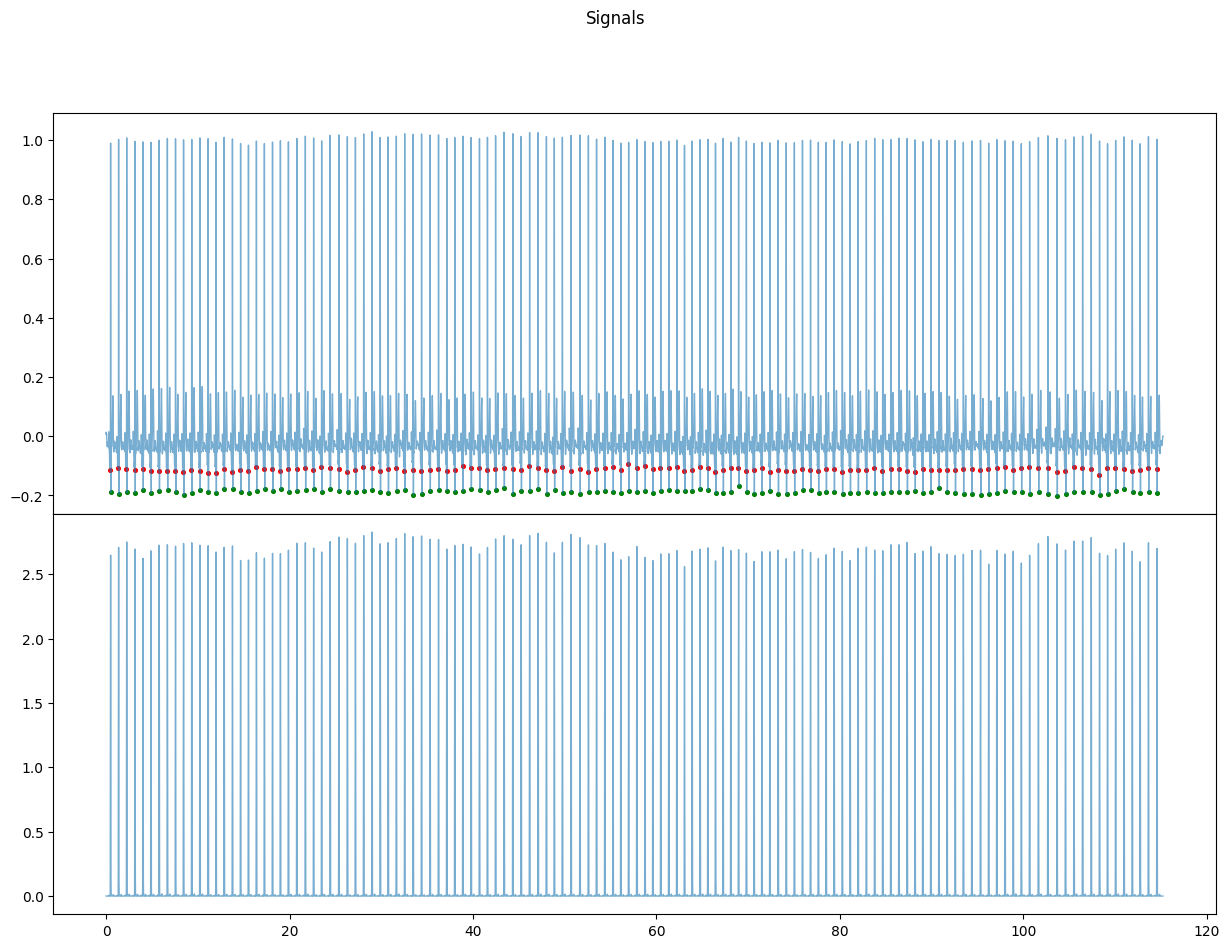

Length of qx: 129
Length of qy: 129
Length of sx: 129
Length of sy: 129
Length of Rx: 129
Length of Ry: 129
Length of qrs_on_x: 129
Length of qrs_on_y: 129
Length of qrs_off_x: 129
Length of qrs_off_y: 129
Length of Px: 129
Length of Py: 129
Length of p_on_x: 129
Length of p_off_x: 129
Length of p_on_y: 129
Length of p_off_y: 129
Length of Tx: 129
Length of Ty: 129
Length of t_on_x: 129
Length of t_off_x: 129
Length of t_on_y: 129
Length of t_off_y: 129
0.9823039130525428


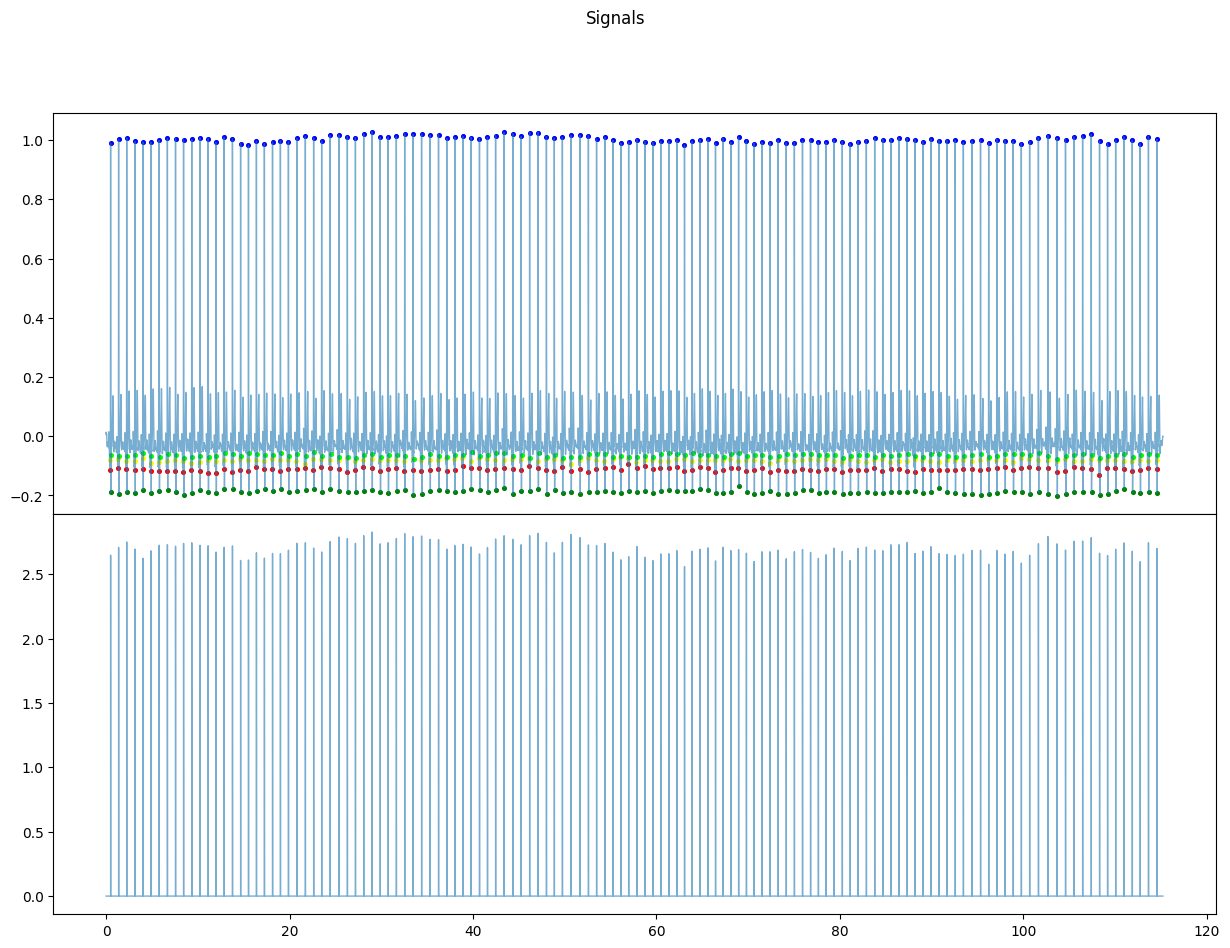

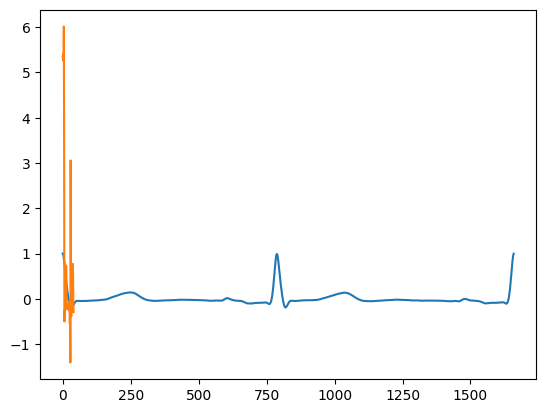

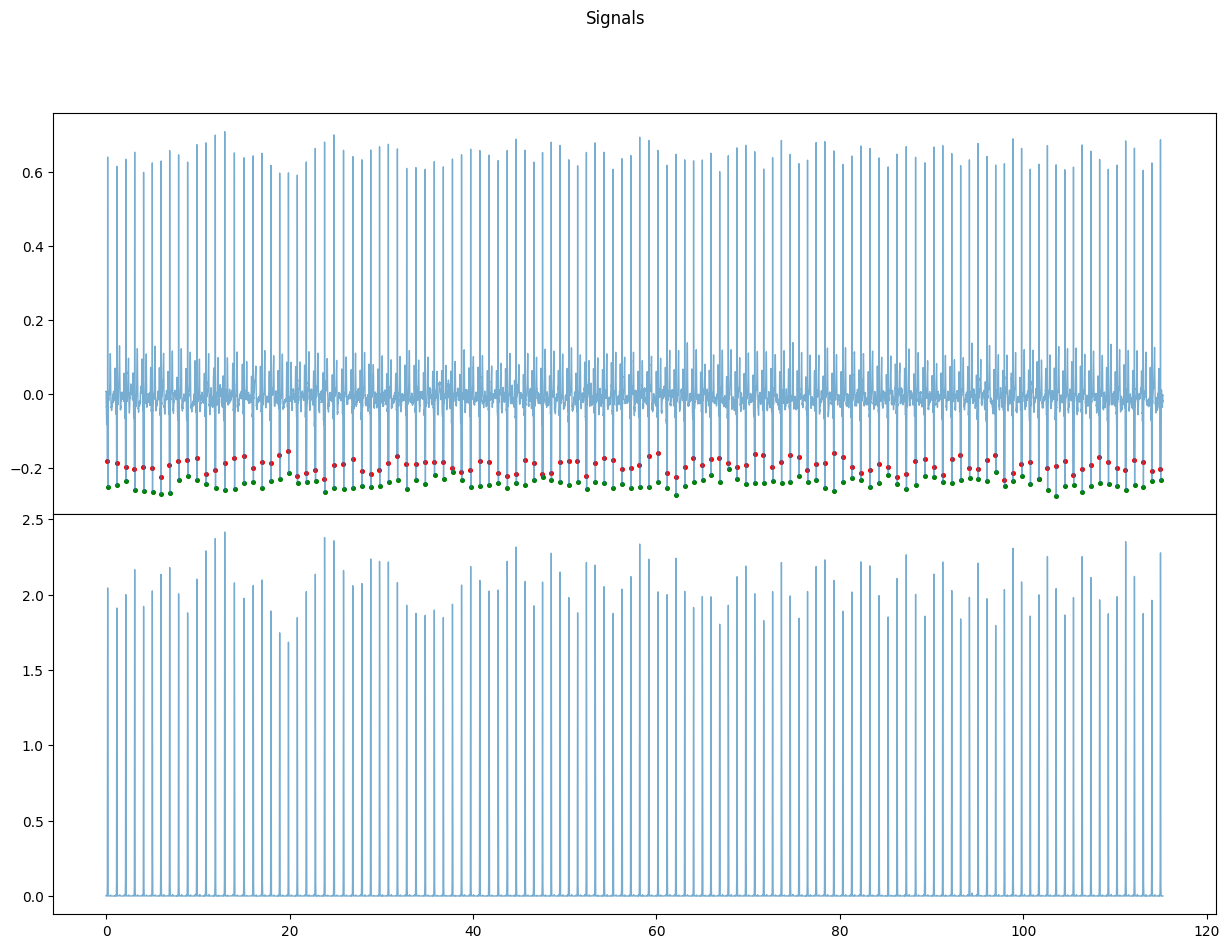

Length of qx: 119
Length of qy: 119
Length of sx: 119
Length of sy: 119
Length of Rx: 119
Length of Ry: 119
Length of qrs_on_x: 119
Length of qrs_on_y: 119
Length of qrs_off_x: 119
Length of qrs_off_y: 119
Length of Px: 119
Length of Py: 119
Length of p_on_x: 119
Length of p_off_x: 119
Length of p_on_y: 119
Length of p_off_y: 119
Length of Tx: 119
Length of Ty: 119
Length of t_on_x: 119
Length of t_off_x: 119
Length of t_on_y: 119
Length of t_off_y: 119
0.5912288512177095


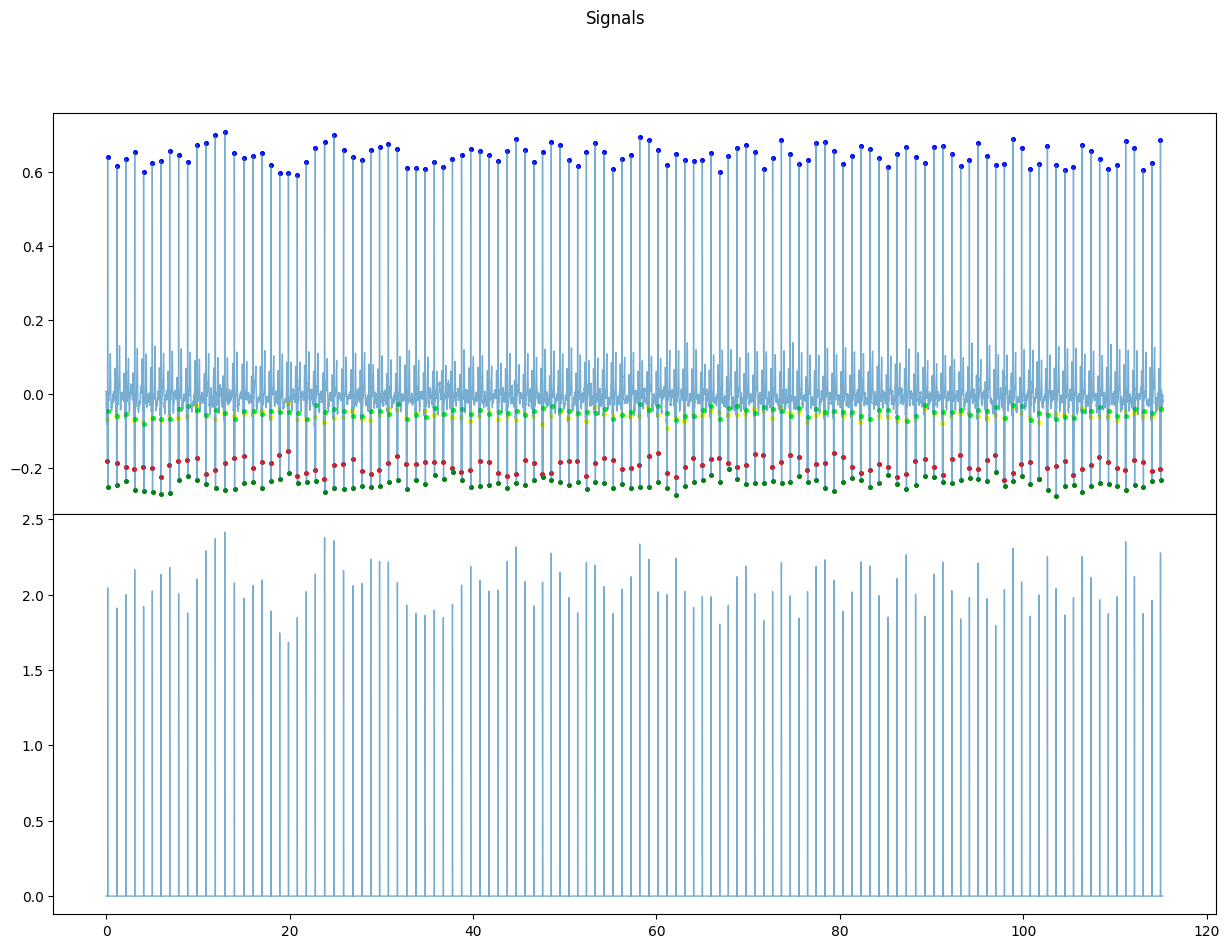

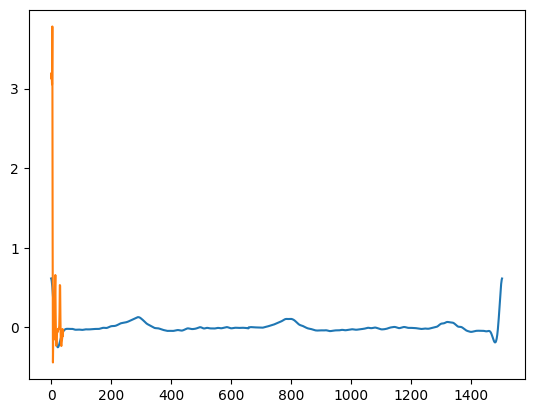

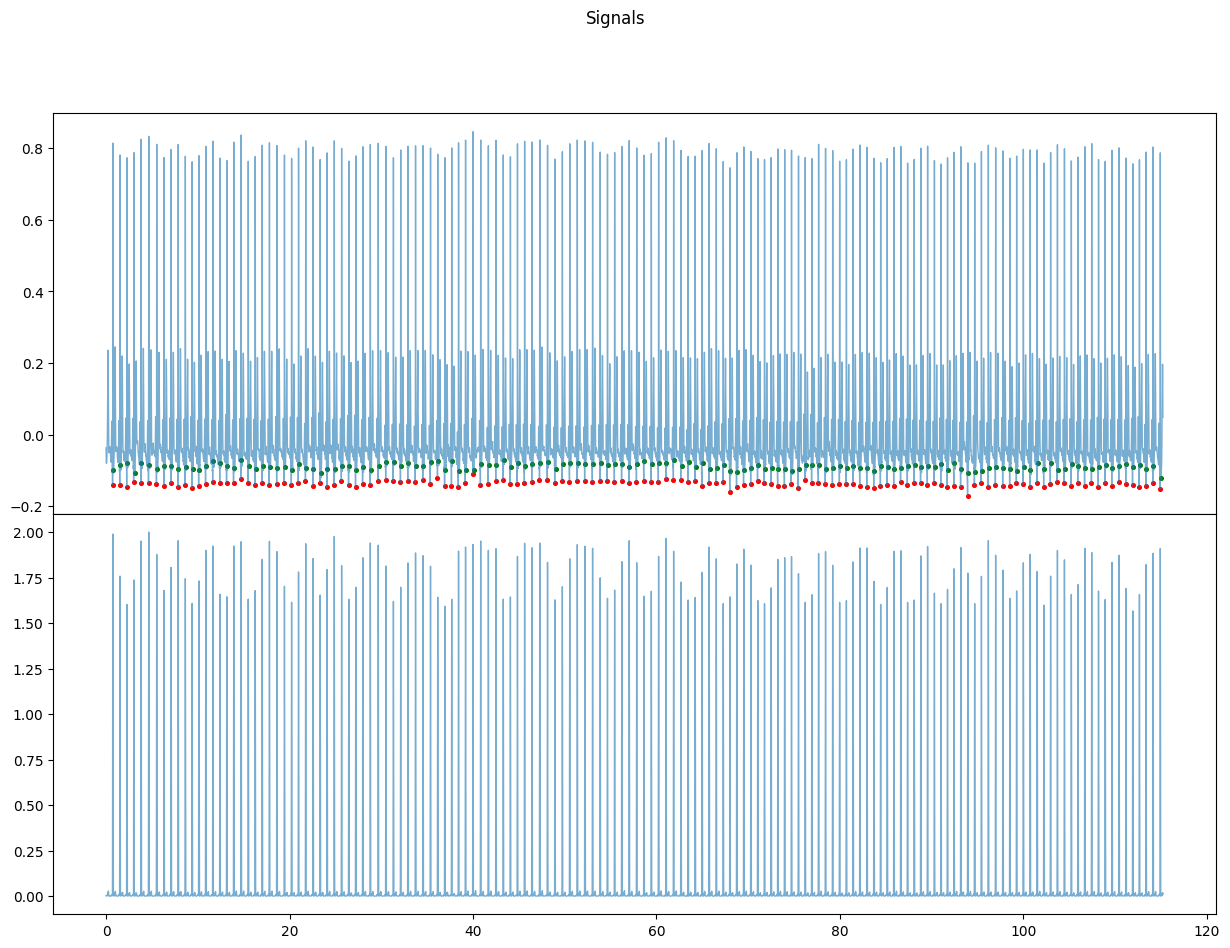

Length of qx: 149
Length of qy: 149
Length of sx: 149
Length of sy: 149
Length of Rx: 149
Length of Ry: 149
Length of qrs_on_x: 149
Length of qrs_on_y: 149
Length of qrs_off_x: 149
Length of qrs_off_y: 149
Length of Px: 149
Length of Py: 149
Length of p_on_x: 149
Length of p_off_x: 149
Length of p_on_y: 149
Length of p_off_y: 149
Length of Tx: 149
Length of Ty: 149
Length of t_on_x: 149
Length of t_off_x: 149
Length of t_on_y: 149
Length of t_off_y: 149
0.7455127382394094


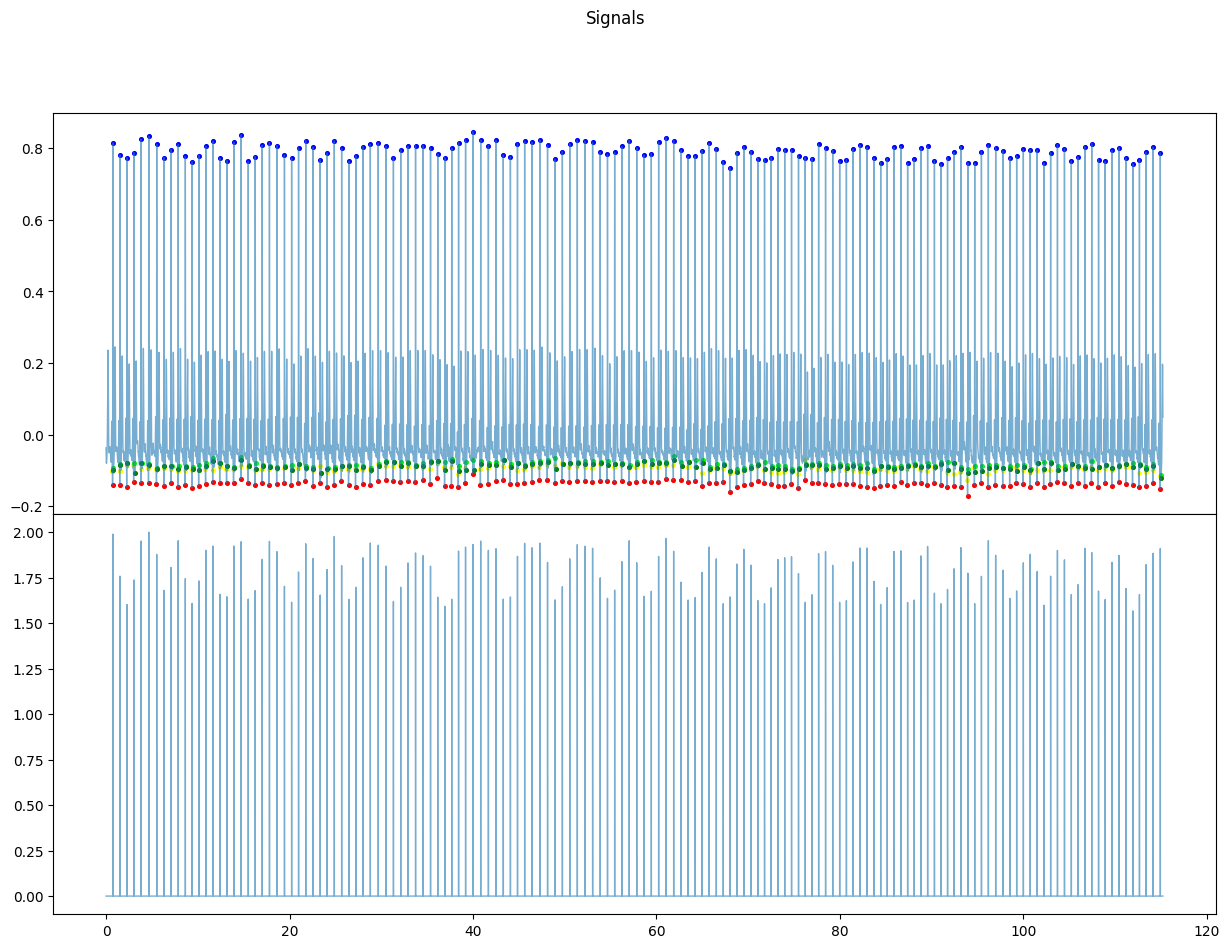

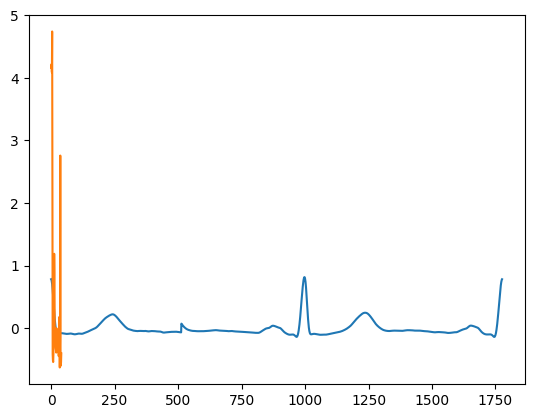

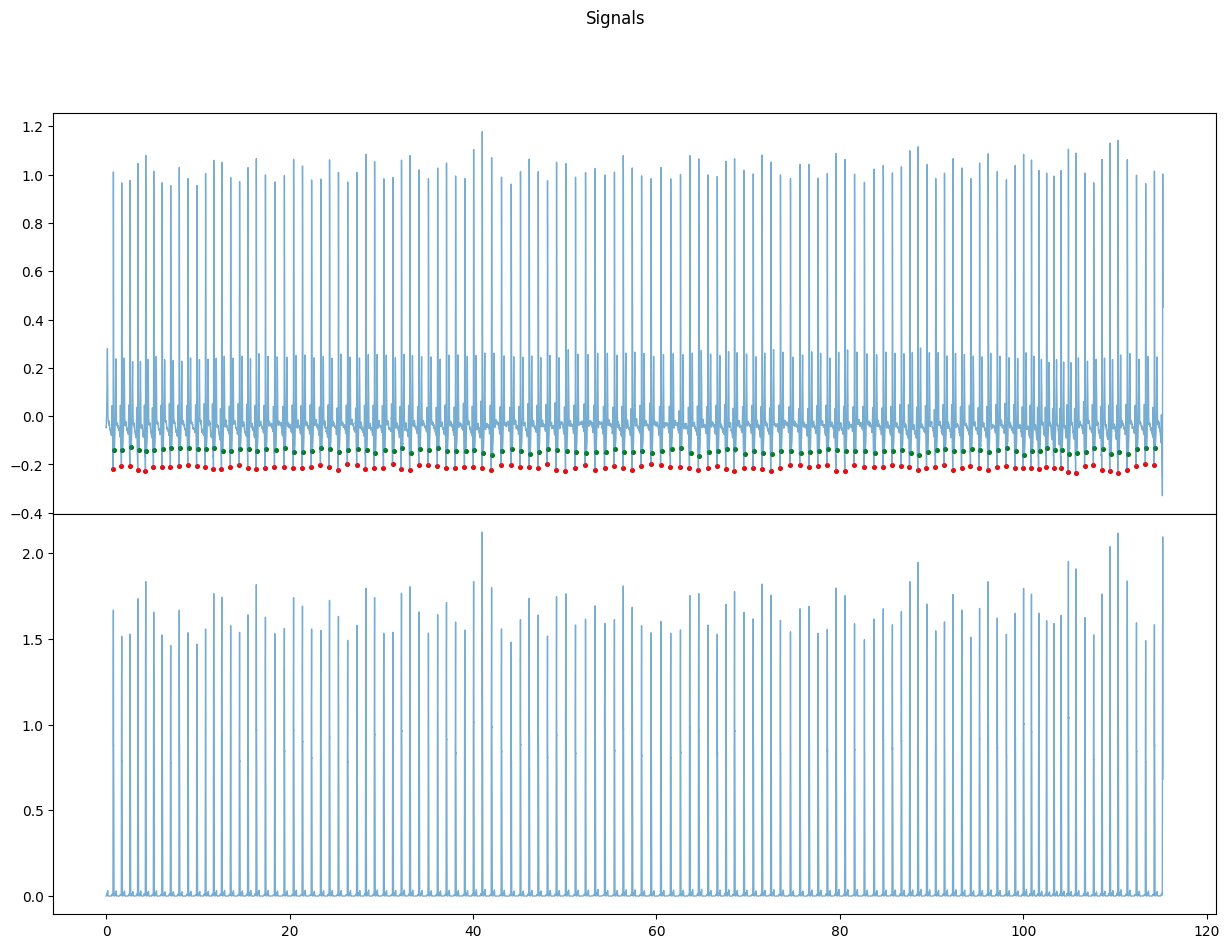

Length of qx: 118
Length of qy: 118
Length of sx: 118
Length of sy: 118
Length of Rx: 118
Length of Ry: 118
Length of qrs_on_x: 118
Length of qrs_on_y: 118
Length of qrs_off_x: 118
Length of qrs_off_y: 118
Length of Px: 118
Length of Py: 118
Length of p_on_x: 118
Length of p_off_x: 118
Length of p_on_y: 118
Length of p_off_y: 118
Length of Tx: 118
Length of Ty: 118
Length of t_on_x: 118
Length of t_off_x: 118
Length of t_on_y: 118
Length of t_off_y: 118
0.9550447105528338


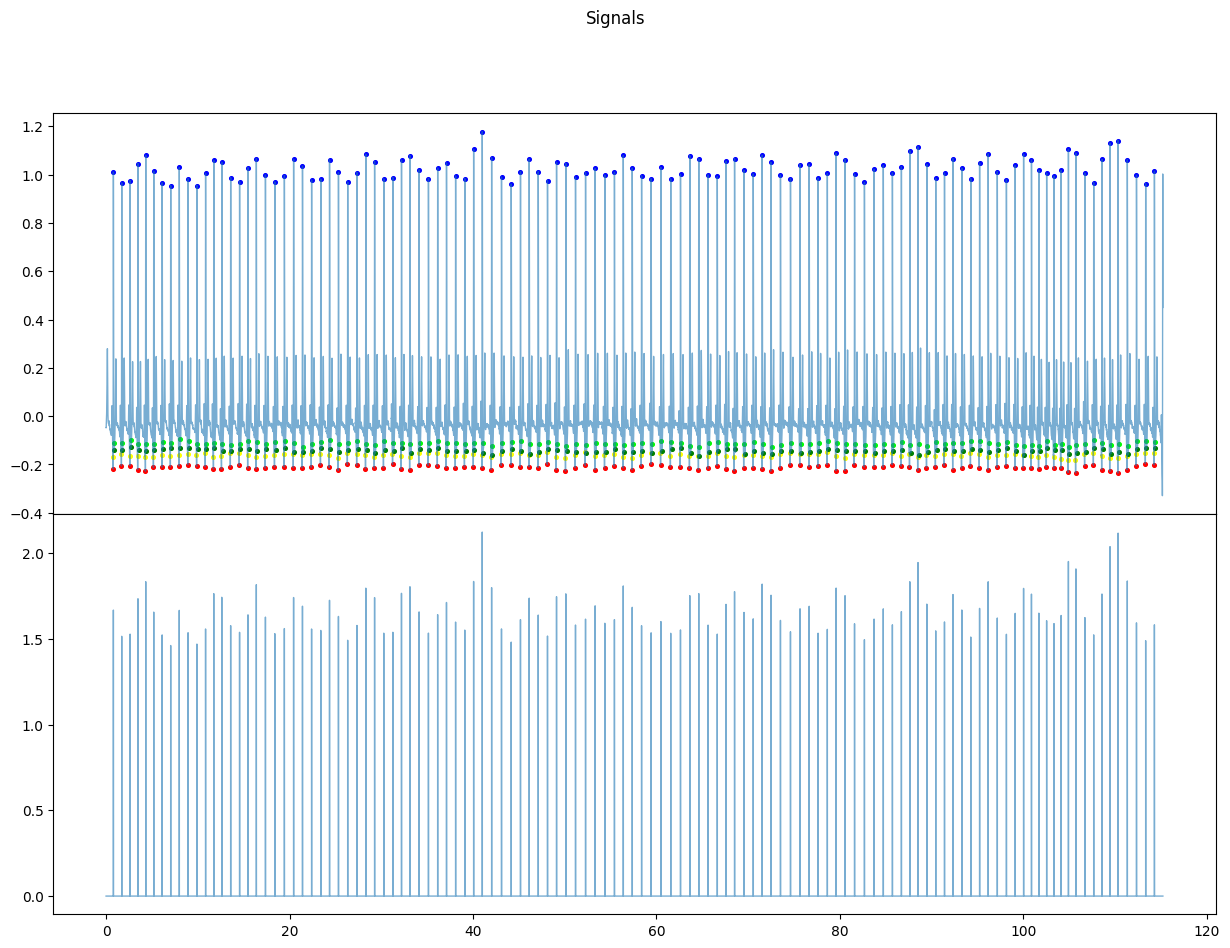

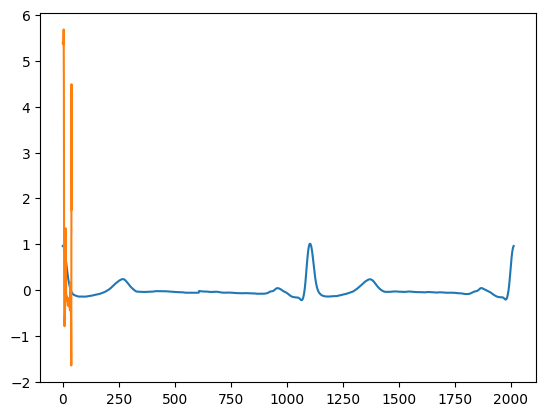

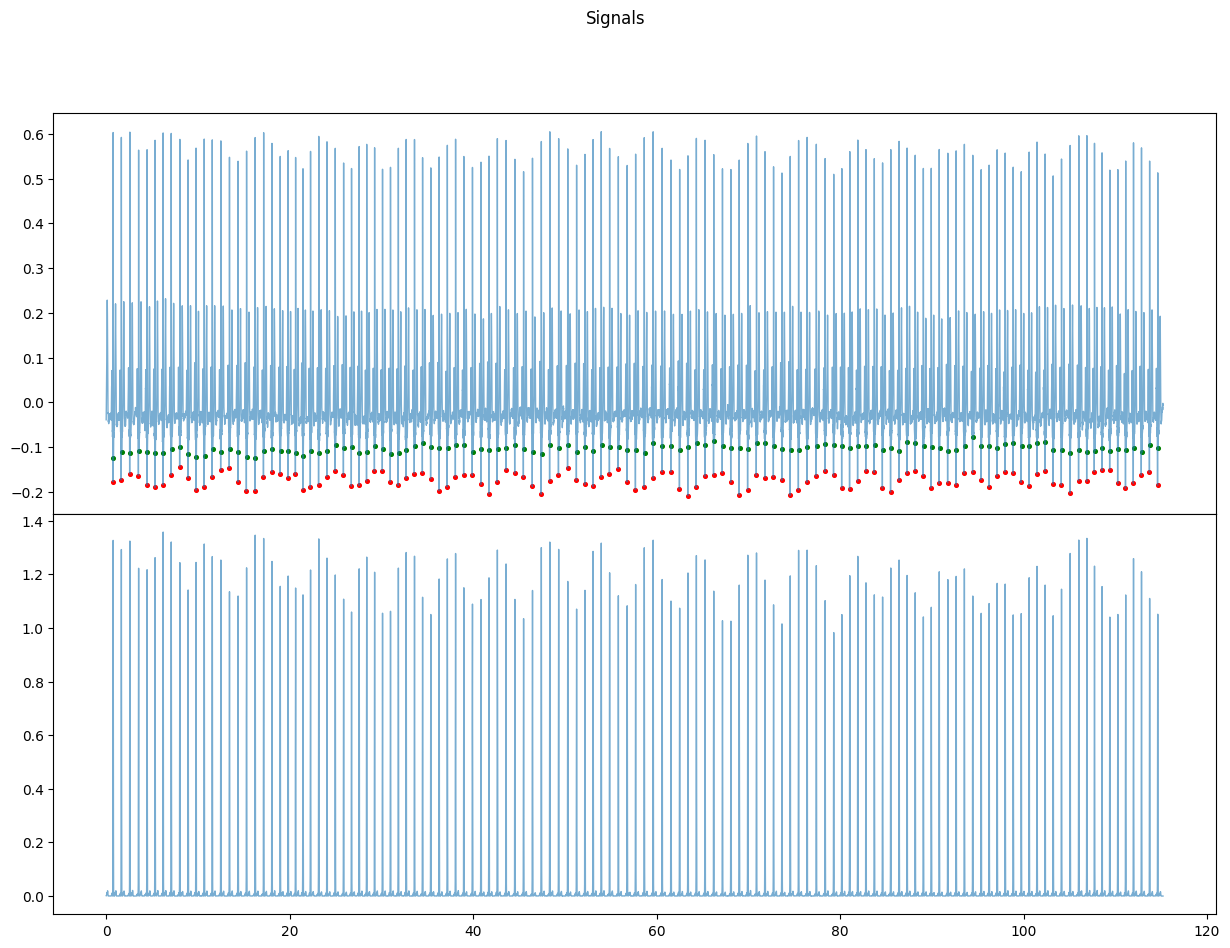

Length of qx: 127
Length of qy: 127
Length of sx: 127
Length of sy: 127
Length of Rx: 127
Length of Ry: 127
Length of qrs_on_x: 127
Length of qrs_on_y: 127
Length of qrs_off_x: 127
Length of qrs_off_y: 127
Length of Px: 127
Length of Py: 127
Length of p_on_x: 127
Length of p_off_x: 127
Length of p_on_y: 127
Length of p_off_y: 127
Length of Tx: 127
Length of Ty: 127
Length of t_on_x: 127
Length of t_off_x: 127
Length of t_on_y: 127
Length of t_off_y: 127
0.5062802522235036


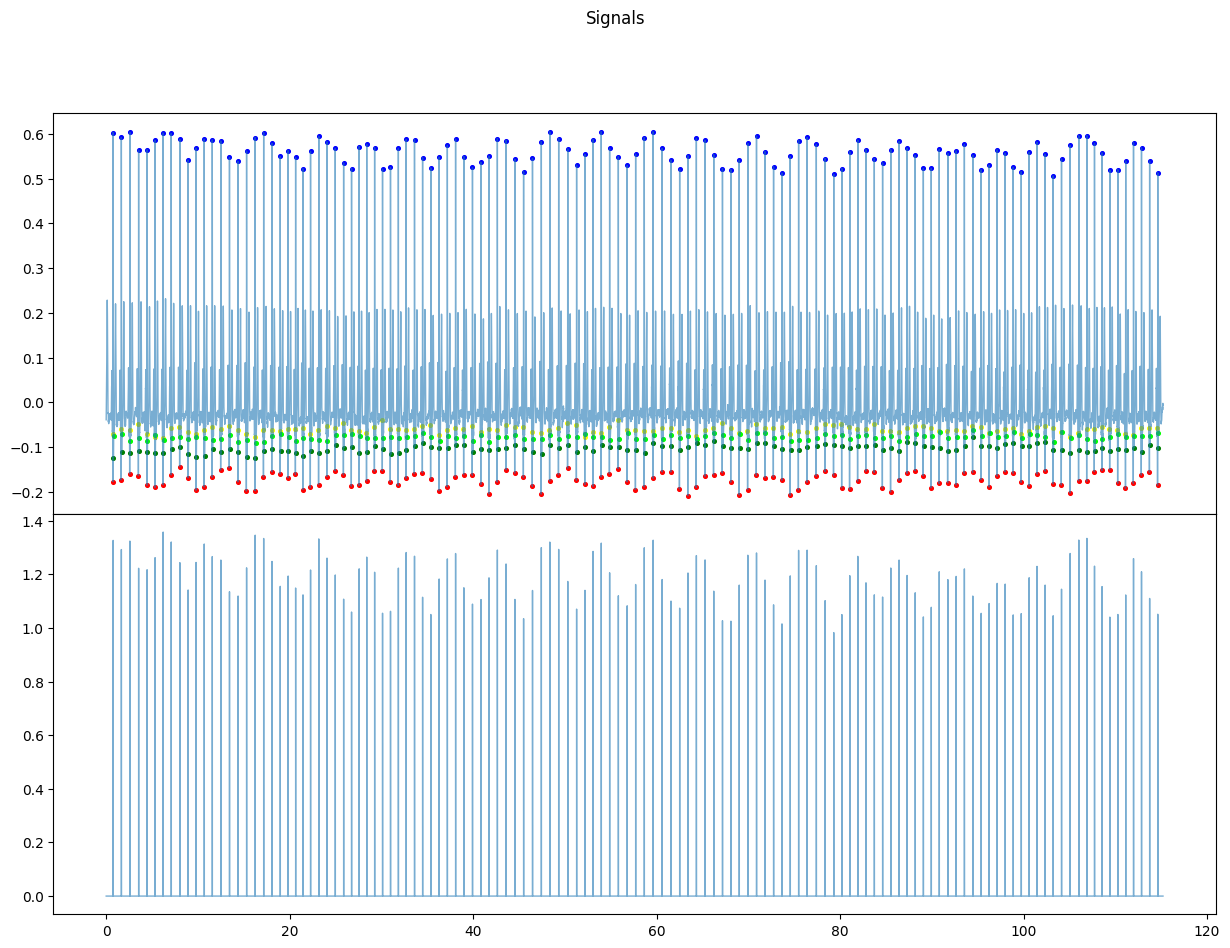

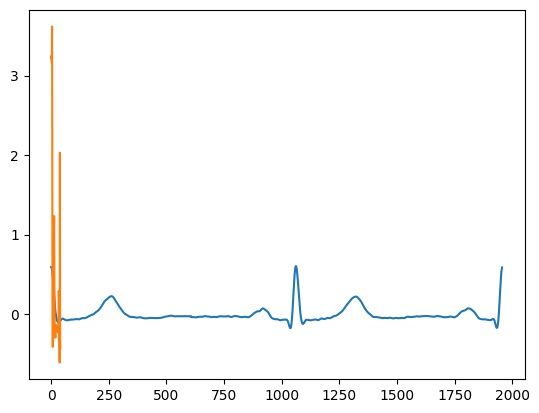

In [11]:
Fiducial_Points_1, non_fiducial_feature1 = Fiducial_Points_Detection(signal_1)
Fiducial_Points_2, non_fiducial_feature2 = Fiducial_Points_Detection(signal_2)
Fiducial_Points_3, non_fiducial_feature3 = Fiducial_Points_Detection(signal_3)
Fiducial_Points_4, non_fiducial_feature4 = Fiducial_Points_Detection(signal_4)
Fiducial_Points_5, non_fiducial_feature5 = Fiducial_Points_Detection(signal_5)

In [12]:
Fiducial_Points_1["class"]=1
Fiducial_Points_2["class"]=2
Fiducial_Points_3["class"]=3
Fiducial_Points_4["class"]=4


In [13]:
fp1arr = Fiducial_Points_1.values
fp2arr = Fiducial_Points_2.values
fp3arr = Fiducial_Points_3.values
fp4arr = Fiducial_Points_4.values
fp5arr = Fiducial_Points_5.values

In [14]:
Data = np.concatenate((fp1arr, fp2arr), axis=0)
Data = np.concatenate((Data, fp3arr), axis=0)
Data = np.concatenate((Data, fp4arr), axis=0)


In [15]:
Data.shape

(515, 23)

In [16]:

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(Data[:,:22], Data[:,-1], test_size=0.3, random_state=42)


In [17]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train the SVM classifier
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(train_data, train_labels)

# Make predictions on the test set
y_pred = svm_classifier.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


lr = LogisticRegression(random_state=0).fit(train_data, train_labels)

# Make predictions on the test set
y_pred = lr.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9806451612903225


c:\Users\Ahmed\.conda\envs\NN\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
y_pred = lr.predict(fp5arr[:,:22])

In [20]:
y_pred

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3.])

In [ ]:
y_pred = lr.predict_proba(fp5arr[:,:22])
for i in y_pred:
    print(round(i[0],3))
    print(round(i[1],3))
    print(round(i[2],3))
    print(round(i[3],3))
    print("---------------")

0.0
0.0
0.855
0.145
---------------
0.0
0.0
0.882
0.118
---------------
0.0
0.0
0.74
0.26
---------------
0.0
0.0
0.334
0.666
---------------
0.0
0.0
0.873
0.127
---------------
0.0
0.0
0.851
0.149
---------------
0.0
0.0
0.784
0.216
---------------
0.0
0.0
0.752
0.248
---------------
0.0
0.0
0.795
0.205
---------------
0.0
0.0
0.846
0.154
---------------
0.0
0.0
0.856
0.144
---------------
0.0
0.0
0.488
0.512
---------------
0.0
0.0
0.561
0.439
---------------
0.0
0.0
0.852
0.148
---------------
0.0
0.0
0.861
0.139
---------------
0.0
0.0
0.853
0.147
---------------
0.0
0.0
0.759
0.241
---------------
0.0
0.0
0.843
0.157
---------------
0.0
0.0
0.843
0.157
---------------
0.0
0.0
0.766
0.234
---------------
0.0
0.0
0.444
0.556
---------------
0.0
0.0
0.776
0.224
---------------
0.0
0.0
0.857
0.143
---------------
0.0
0.0
0.803
0.197
---------------
0.0
0.0
0.812
0.188
---------------
0.0
0.0
0.593
0.407
---------------
0.0
0.0
0.793
0.207
---------------
0.0
0.0
0.836
0.164
----------

#Testing

In [ ]:
time = 10*1000
p1 = patient_1.p_signal[:time ,0]


In [ ]:
y_pred 


array([[9.95056150e-009, 1.60367695e-192, 1.66798464e-001,
        8.33201526e-001],
       [1.16591283e-008, 9.81533169e-192, 2.30177608e-001,
        7.69822380e-001],
       [1.48022704e-008, 5.20153406e-191, 2.65902168e-001,
        7.34097817e-001],
       [1.16768771e-008, 2.69812687e-190, 2.03931892e-001,
        7.96068096e-001],
       [1.27049885e-008, 1.09630122e-189, 2.15039510e-001,
        7.84960477e-001],
       [2.70856499e-008, 6.63828049e-189, 2.36620112e-001,
        7.63379861e-001],
       [6.32104709e-008, 6.03147184e-188, 2.28775602e-001,
        7.71224335e-001],
       [4.59271173e-008, 3.46223338e-187, 2.84561162e-001,
        7.15438792e-001],
       [2.26966878e-008, 1.20853773e-186, 9.72969124e-002,
        9.02703065e-001],
       [4.42224700e-008, 1.16370015e-185, 2.64055600e-001,
        7.35944356e-001],
       [4.30459034e-008, 5.97011089e-185, 2.29665367e-001,
        7.70334590e-001],
       [9.97433238e-008, 6.90884147e-184, 3.52882480e-001,
      

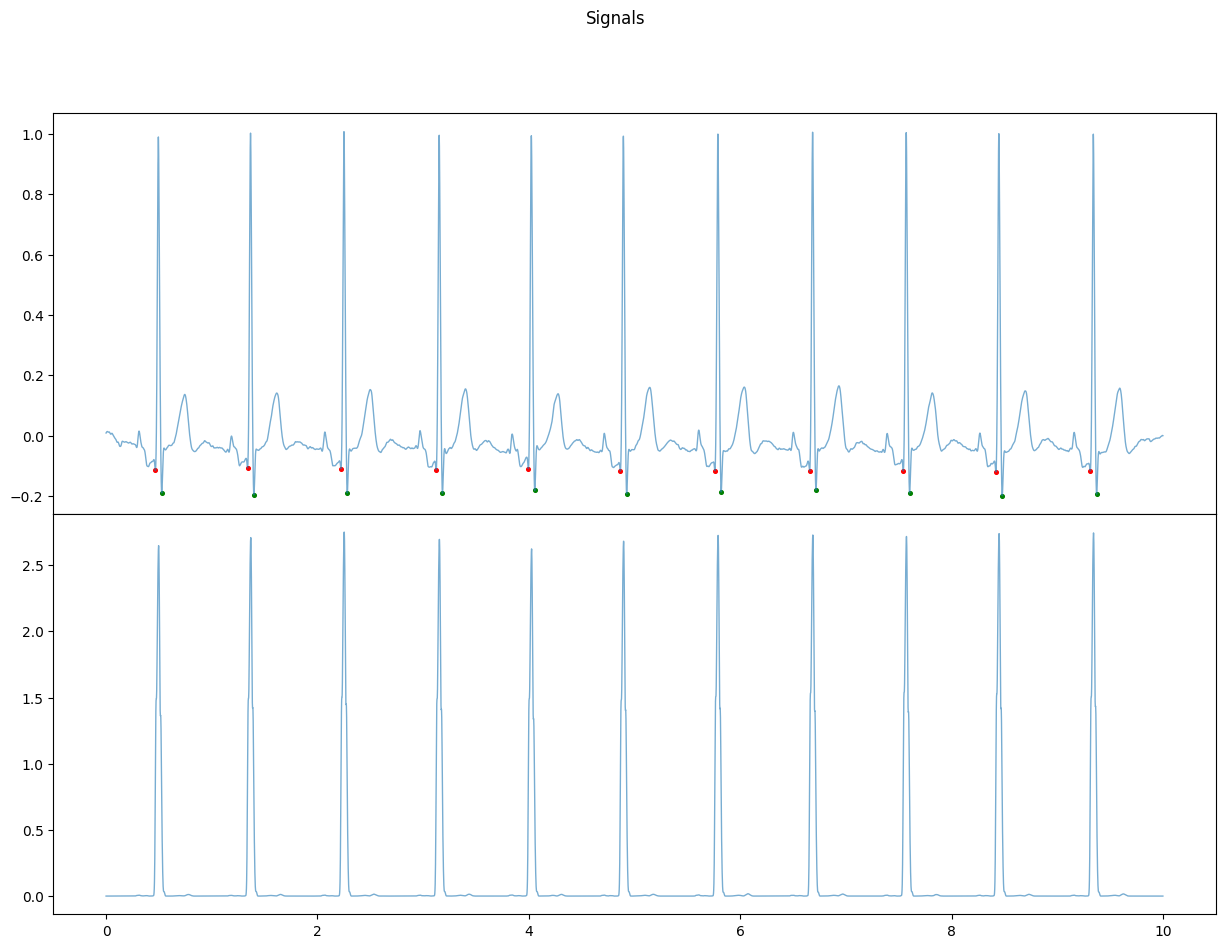

Length of qx: 11
Length of qy: 11
Length of sx: 11
Length of sy: 11
Length of Rx: 11
Length of Ry: 11
Length of qrs_on_x: 11
Length of qrs_on_y: 11
Length of qrs_off_x: 11
Length of qrs_off_y: 11
Length of Px: 11
Length of Py: 11
Length of p_on_x: 11
Length of p_off_x: 11
Length of p_on_y: 11
Length of p_off_y: 11
Length of Tx: 11
Length of Ty: 11
Length of t_on_x: 11
Length of t_off_x: 11
Length of t_on_y: 11
Length of t_off_y: 11
0.9898980195663987


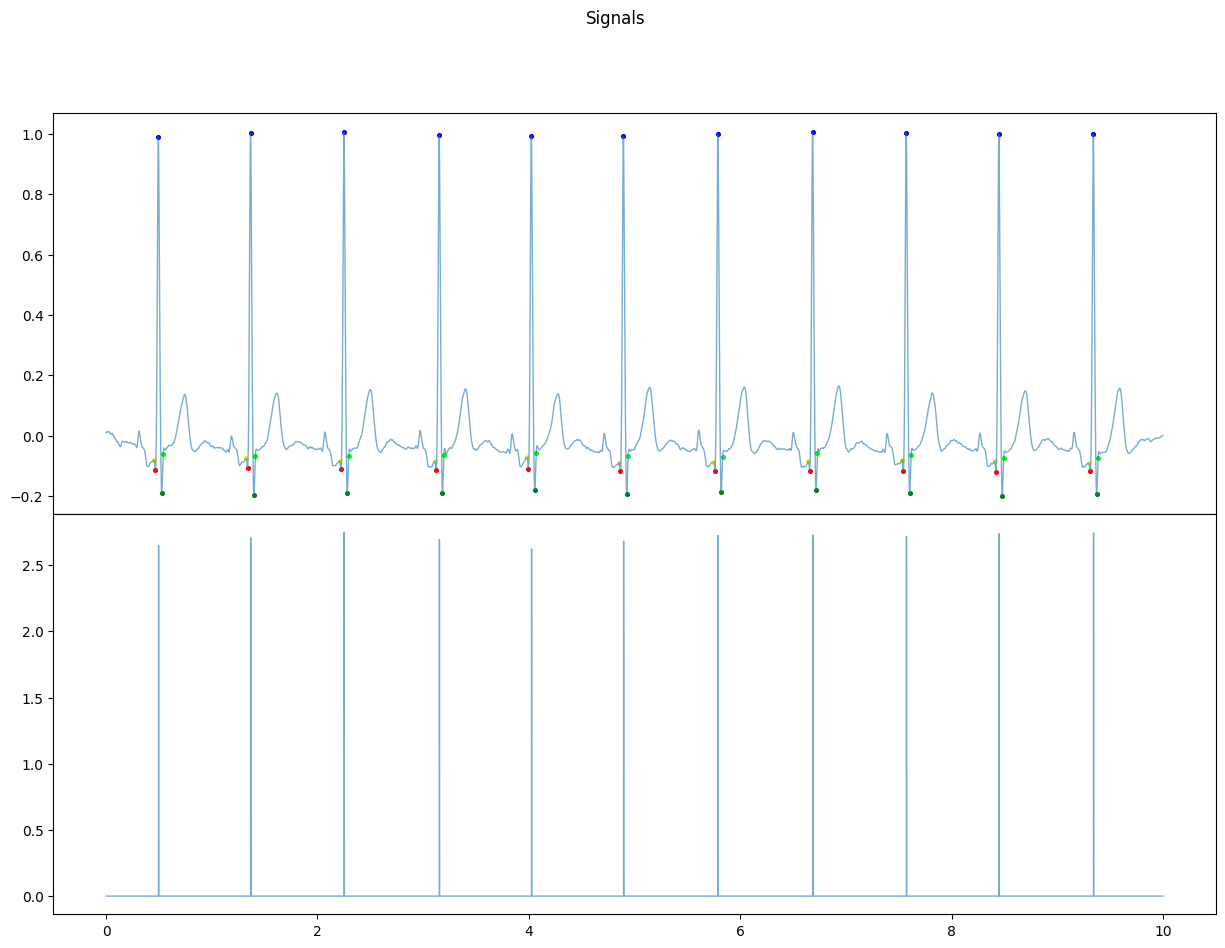

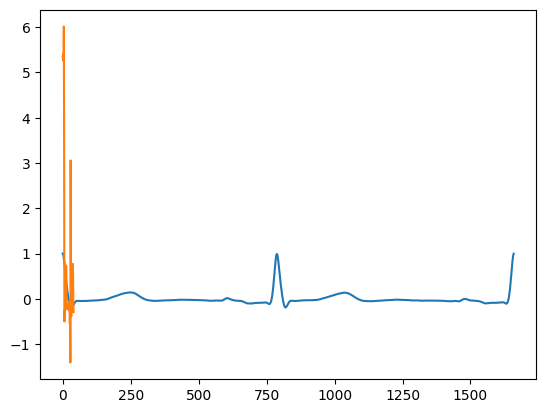

In [ ]:
Fiducial_Points_p1_1, non_fiducial_feature1 = Fiducial_Points_Detection(p1)
testp1 = Fiducial_Points_p1_1.values
y_pred = svm_classifier.predict(testp1)
